#Proposal for clustering DNA methylation patterns

### Alex Williams, 05/05/2015

<img src="bipolar.png" style="width: 420px;float:right;padding-left:20px"/>

A fundamental problem in neuroscience is inferring the number of cell types that comprise brain circuits (see, e.g., [Seung and Sümbül, 2014](http://dx.doi.org/10.1016/j.neuron.2014.08.054)). Can differential DNA methylation patterns across cell types provide insight into this problem?

[Bisulfite sequencing](http://en.wikipedia.org/wiki/Bisulfite_sequencing) datasets collected from mixed tissue samples contain [allele-specific methylation](http://dx.doi.org/10.1101/gr.104695.109) (ASM) and [cell-specific methylation](10.1186/gb-2013-14-8-r94) (CSM) patterns. Perhaps the simplest example to understand is bipolar methylation. In this case, reads that are mapped to the same locus are either heavily methylated or heavily unmethylated; this is shown in the figure to the right (reproduced from [Wu et al., 2015](http://dx.doi.org/10.1186/s12859-014-0439-2)). Here, the black circles show a methylated site, the open circles show a site that was eligible to be methylated, but was not methylated. The lack of a circle indicates that data was unavailable for that read.

In the case of bipolar methylation each read can be assigned to one of two clusters (highly methylated and unmethylated). However, there is reason to believe that the natural number of clusters is much higher in datasets with mixed cell types. The code below presents a reasonable generative model.

** Questions: **

* A bisulfite sequencing experiment is parameterized by the genome length, the average read length, and the number of reads. How many clusters we can faithfully identify depend on these parameters, as well as on the relative cluster sizes and distance between clusters. Can we derive estimates/bounds on performance given this information? How does current sequencing technology compare to what would be needed?

* Can we validate a clustering method by pooling data from sorted cell types (e.g. methylation patterns from glia vs. neurons) and recovering the original labels?

* Can this method distinguish between subtypes of neurons that can't be sorted/separated by genetic markers?

* It seems like it might be useful to infer the number of clusters locally (e.g. at a given locus), since some genes are more likely to show differential methylation than others. On the other hand, it would also be useful to obtain a global estimate of the number of clusters in a sequencing dataset, as this would provide information on the number of cell types in the sample. Can we develop a single method that provides insight into both of these questions? I'm envisioning something that infers the number of differential methylation patterns in a continuous manner across the length of the genome.

** Previous Work: **

* [Shoemaker et al. (2010)](http://dx.doi.org/10.1101/gr.104695.109) Allele-specific methylation is prevalent and is contributed by CpG-SNPs in the human genome. *Genome Res.* 20: 883-889
* [Guintivano et al. (2013)](http://dx.doi.org/10.4161/epi.23924) A cell epigenotype specific model for the correction of brain cellular heterogeneity bias and its application to age, brain region and major depression. *Epigenetics.* 8(3):290-302.
* [Montaño et al. (2013)](http://genomebiology.com/content/14/8/R94) Measuring cell-type specific differential methylation in human brain tissue. *Genome Biology.* 14:R94
* [Wu et al. (2015)](http://dx.doi.org/10.1186/s12859-014-0439-2) Nonparametric Bayesian clustering to detect bipolar methylated genomic loci. *BMC Bioinformatics.* 16:11 

** Opportunities for improvement: **

* Most previous studies, with the exception of [Wu et al. (2015)](http://dx.doi.org/10.1186/s12859-014-0439-2) test for differential methylation in sorted cell populations, but not all cell types in the brain have been identified or are easily sorted. Techniques for clustering methylation patterns in mixed samples seem to have room for improvement.

* Previous studies appear to only consider small regions with high coverage. For example, [Wu et al. (2015)](http://dx.doi.org/10.1186/s12859-014-0439-2) restrict their analysis to collections four sequential methylation-eligible sites with at least 10X read coverage. This throws away potential information from nearby sites, which might be useful despite relatively low coverage.

* Previous work has considered methylation on C-G sites only, but there are other methylation eligible sites that could be included.

##Other Important Background Information (provided by Eran)

- DNA methylation typically occurs in a [CG dinucleotide](http://en.wikipedia.org/wiki/CpG_site) context
- CG sites are sparse in the genome; they are highly depleted compared to what you’d expect for a random sequence
- CG sites are concentrated in "CG islands” near gene promoters
- For this reason, most of the genome is not covered by analysis that focuses on CG sites
- CH methylation is a unique (and only recently discovered) feature of brain and stem cell methylomes
- CH sites are much more abundant than CG sites; they constitute ~16% of all nuncleotides, so any given 100-bp read should overlap ~10-20 CH sites
- Unlike CG methylation, the genome-wide average level of CH methylation appears to be quite different across cell types.  It is much higher in neurons than glia, and even higher in PV interneurons than in excitatory neurons. In non-brain cell types (liver, pancreas, etc.) it is virtually undetectable.
- Thus, using CH methylation we might expect we could have many more bits of information for assigning reads to cell types.
- However, the CH methylation level is lower than the CG methylation level, even in cell types that have the highest mCH (e.g. PV cells).  The methylation level depends on the local sequence context, with CAC sites having the highest methylation level — but if we restrict to just CAC sites then we are again selecting a relatively sparse subset of the genome. Ideally we’d like to combine info from different sequence contexts.

# A simple generative model

This is based on [Wu et al. (2015)](http://dx.doi.org/10.1186/s12859-014-0439-2)
    
$$X_{i,j} \sim \text{Bernoulli}(\theta_{i,j}), ~~~~~i = 1,...,N, j = 1,...,W$$

$$\mathbf{\theta_{i}} = [\theta_{i,1}, ... , \theta_{i,W}]^T$$

$$\mathbf{\theta_{i}} \sim G~,~~ G \sim \text{DP}(\alpha,G_0)$$

$$G_0 = \prod_{j=1}^W G_{0j} ~,~~ G_{0j} \sim \text{Beta}(\alpha_j,\beta_j) $$

** Assumptions: **

* Fixed read length, $W$
* Fixed start/end of read. More realistic would be to have partially overlapping reads.
* Methylation at each site is a Bernoulli random variable with probability $\theta_{c,w}$



In [1]:
using Distributions
using PyPlot
include("methylation_functions.jl"); # some functions to generate data

INFO: Loading help data...


generate_reads (generic function with 1 method)

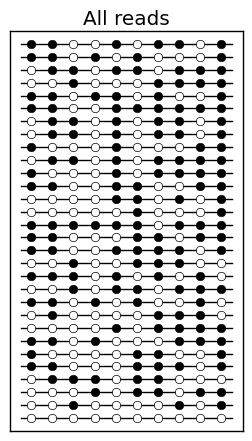

PyObject <matplotlib.text.Text object at 0x7fc021e465d0>

In [2]:
# Generate synthetic data using Pólya urn scheme
#  X = n-by-w matrix of reads
#  P = nc-by-w matrix of methylation probabilities
#  c = n-by-1 vector of cluster assignments
X,P,c = generate_data()
N,W = size(X)           # number of reads (N) and length of reads (W)

# Plot the raw methylation data (assign everything to one cluster)
figure(figsize=(3,5))
plot_meth(X,ones(N))

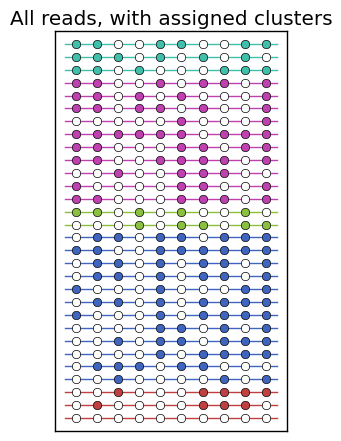

PyObject <matplotlib.text.Text object at 0x7fbff4da4a10>

In [3]:
# Plot the reads organized by their true clusters
figure(figsize=(3,5))
plot_meth(X,c)

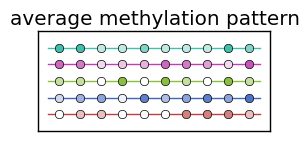

In [4]:
# Average methylation pattern in each cluster
figure(figsize=(3,size(P,1)*0.25))
plot_meth_avg(X,c)
show()